## Import libraries and set device

In [67]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Prepare datasets

In [68]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [69]:
len(train_data), len(test_data)

(60000, 10000)

In [70]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

#### Look at sample image

(-0.5, 27.5, 27.5, -0.5)

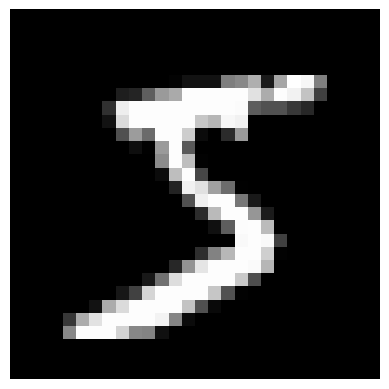

In [71]:
image = train_data[0][0]
plt.imshow(image.squeeze(), cmap="gray")
plt.axis(False)

#### Use dataloader to split data into batches

In [72]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False) 

## Make accuracy, training, and testing functions

In [73]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [74]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device=device):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

In [75]:
def test_step(model,
              data_loader,
              loss_fn,
              optimizer,
              accuracy_fn,
              device=device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss
            acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_acc += acc
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


## Make Tiny VGG CNN model

In [76]:
class MNIST_CNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    def forward(self, x):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.classifier(x)
        return x

#### Initialize model and set loss function and optimizer

In [77]:
model = MNIST_CNN(input_shape=1,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

## Train and test model. Print out loss and accuracy

In [78]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch}\n --------------------------")
    train_step(model=model,
            accuracy_fn=accuracy_fn,
            loss_fn=loss_fn,
            data_loader=train_dataloader,
            optimizer=optimizer)
    test_step(model=model,
              accuracy_fn=accuracy_fn,
              loss_fn=loss_fn,
              data_loader=train_dataloader,
              optimizer=optimizer)

Epoch 0
 --------------------------


Train Loss: 0.48004 | Train Acc: 83.14%
Test Loss: 0.08705 | Test Acc: 97.31%
Epoch 1
 --------------------------
Train Loss: 0.07577 | Train Acc: 97.73%
Test Loss: 0.05610 | Test Acc: 98.24%
Epoch 2
 --------------------------
Train Loss: 0.05698 | Train Acc: 98.27%
Test Loss: 0.05123 | Test Acc: 98.37%
Epoch 3
 --------------------------
Train Loss: 0.04619 | Train Acc: 98.59%
Test Loss: 0.03558 | Test Acc: 98.90%
Epoch 4
 --------------------------
Train Loss: 0.04127 | Train Acc: 98.64%
Test Loss: 0.02950 | Test Acc: 99.06%
Epoch 5
 --------------------------
Train Loss: 0.03514 | Train Acc: 98.88%
Test Loss: 0.04909 | Test Acc: 98.34%
Epoch 6
 --------------------------
Train Loss: 0.03216 | Train Acc: 99.03%
Test Loss: 0.02726 | Test Acc: 99.17%
Epoch 7
 --------------------------
Train Loss: 0.02981 | Train Acc: 99.06%
Test Loss: 0.01984 | Test Acc: 99.44%
Epoch 8
 --------------------------
Train Loss: 0.02749 | Train Acc: 99.14%
Test Loss: 0.02255 | Test Acc: 99.30%
Epoch 9
 -

## Visualize the performance of the model

#### Plot a confusion matrix to see the most common classification mistakes

In [79]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

In [80]:
len(y_pred_tensor)

10000

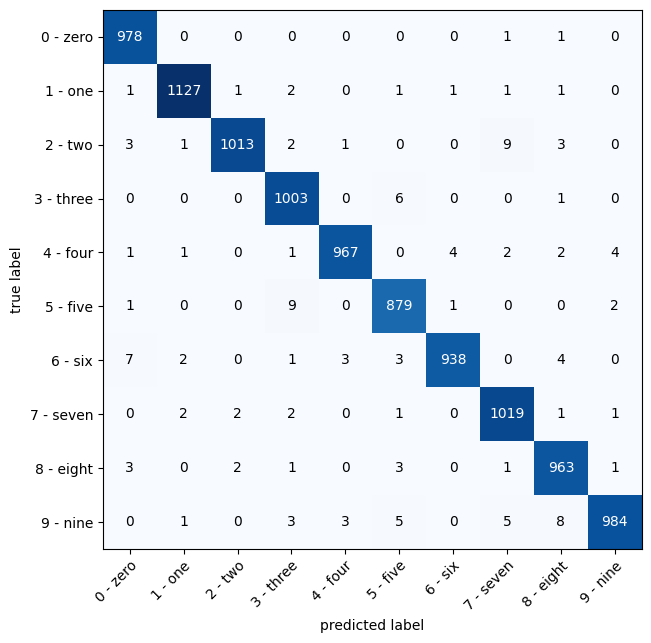

In [81]:
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

#### Plot every incorrect prediction, and label what the model predicted and what the actual label was

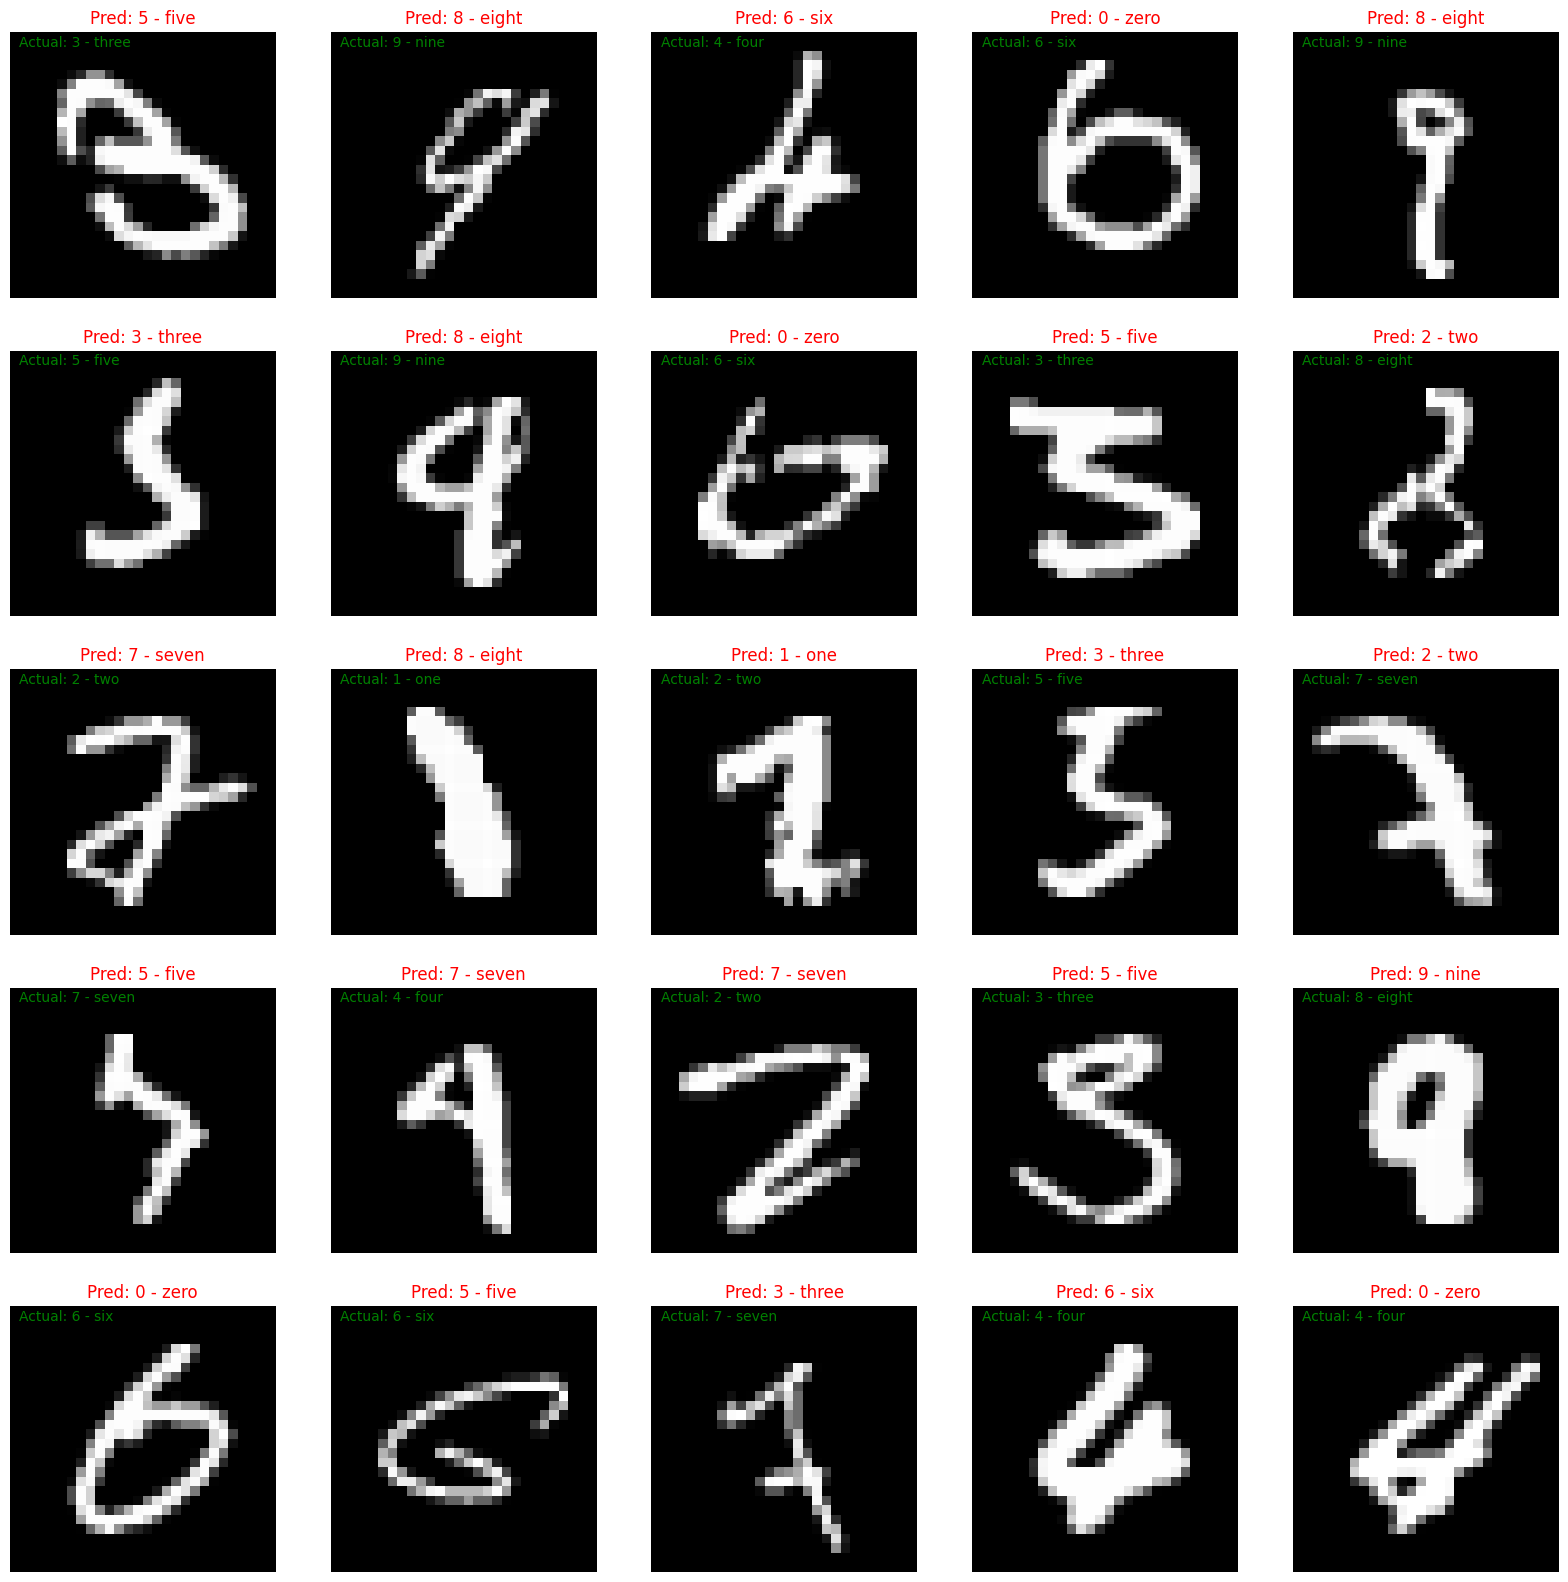

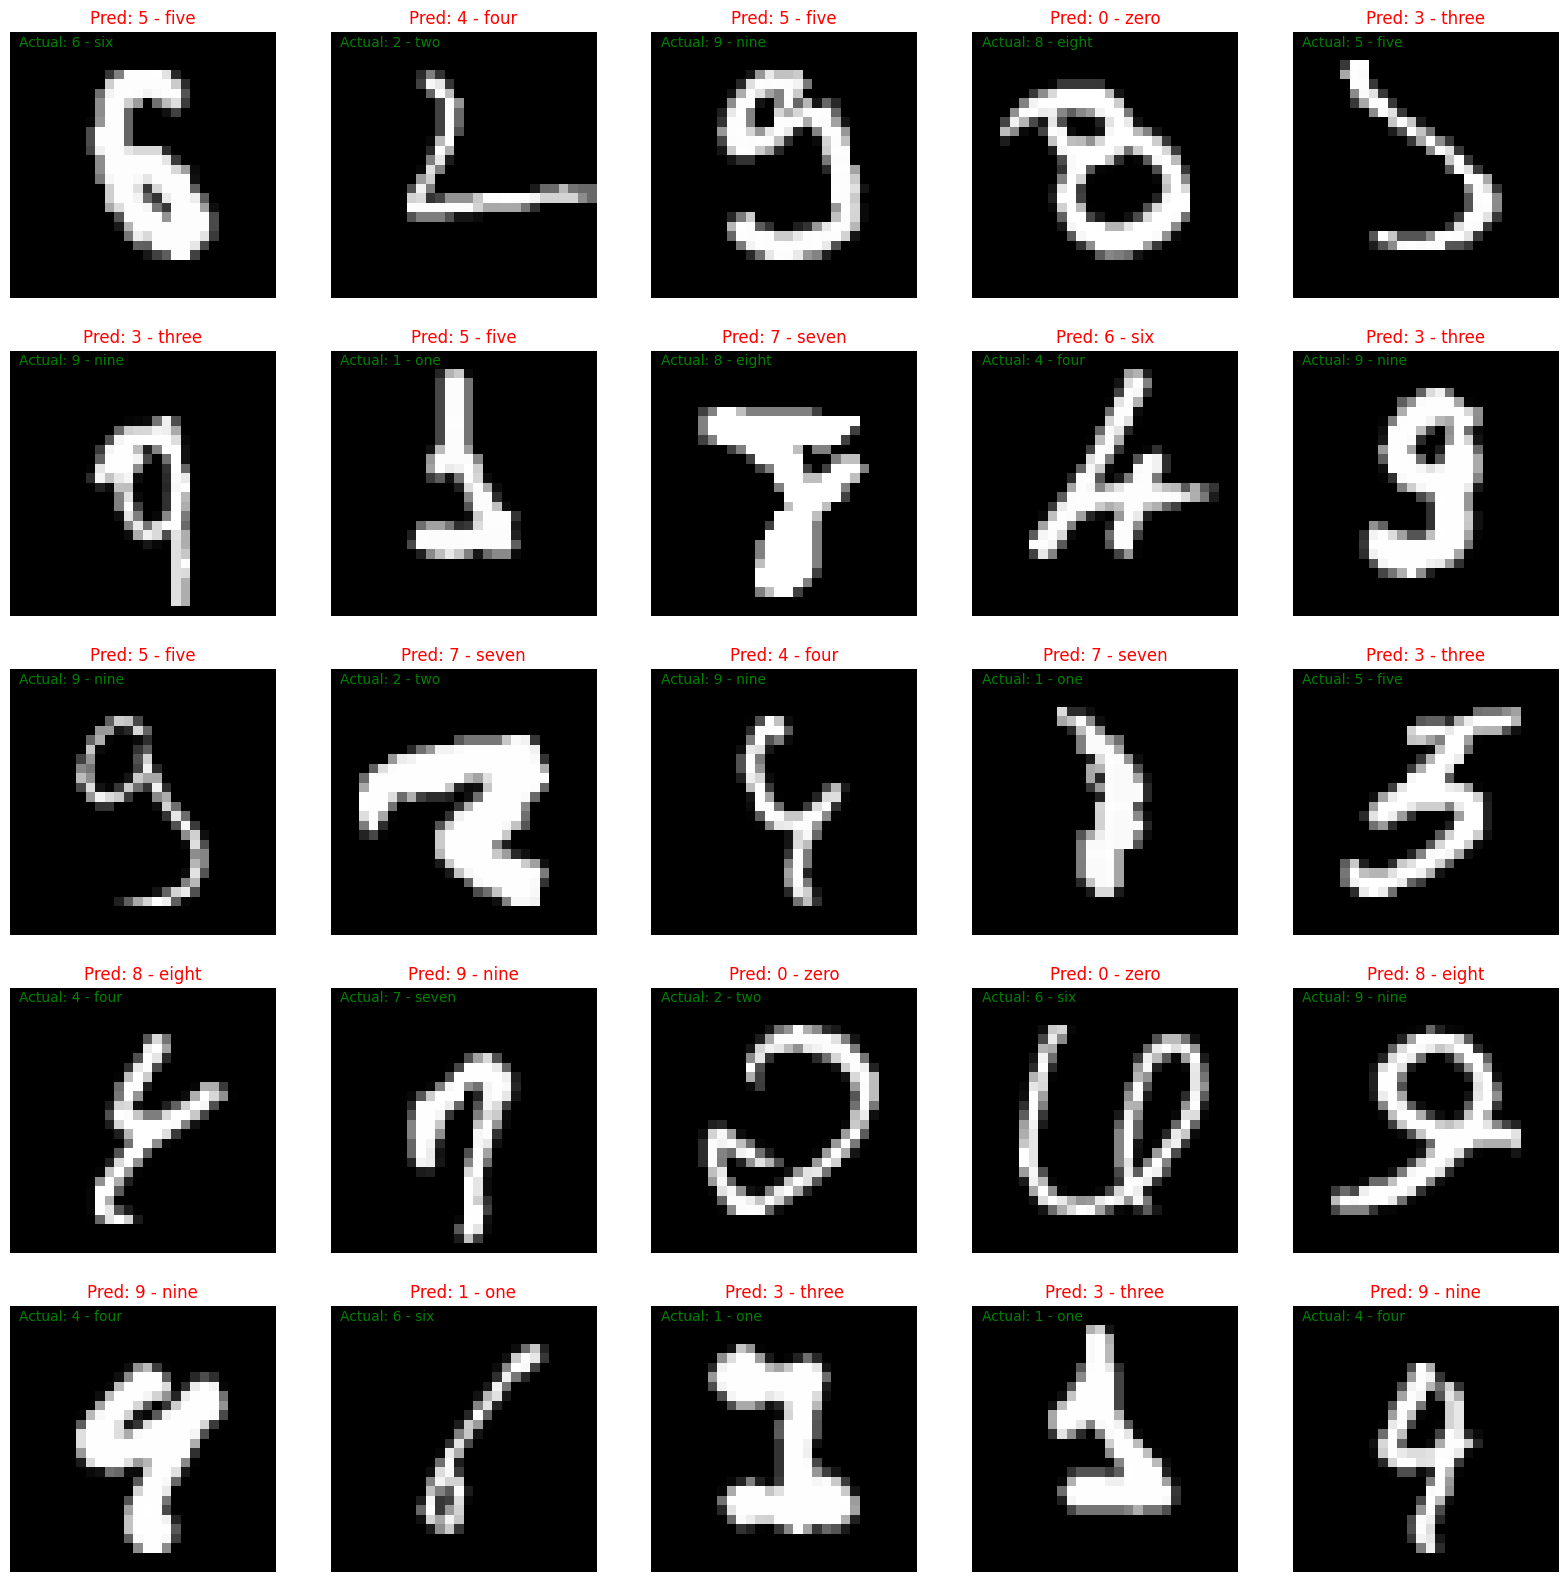

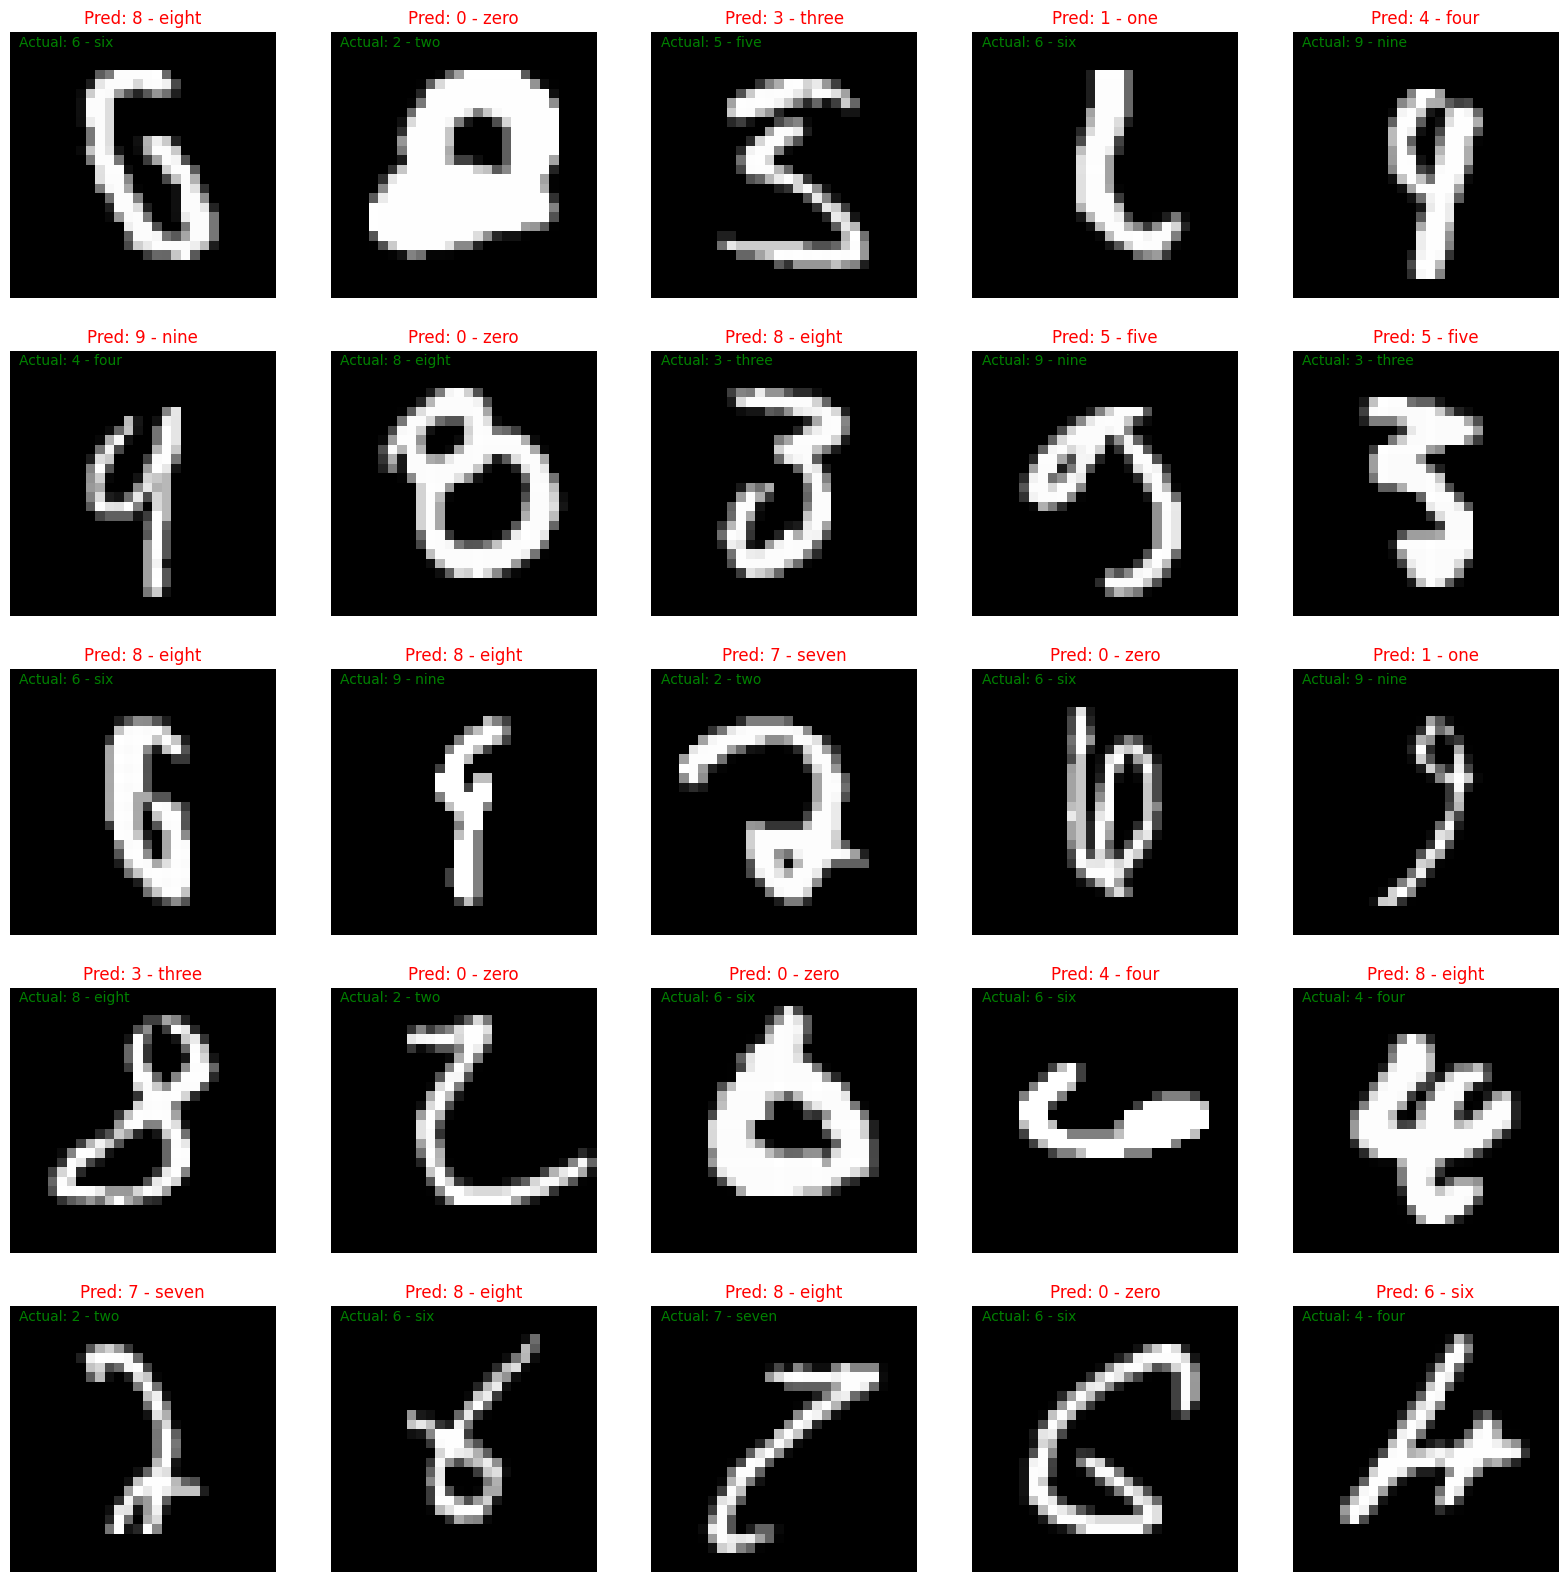

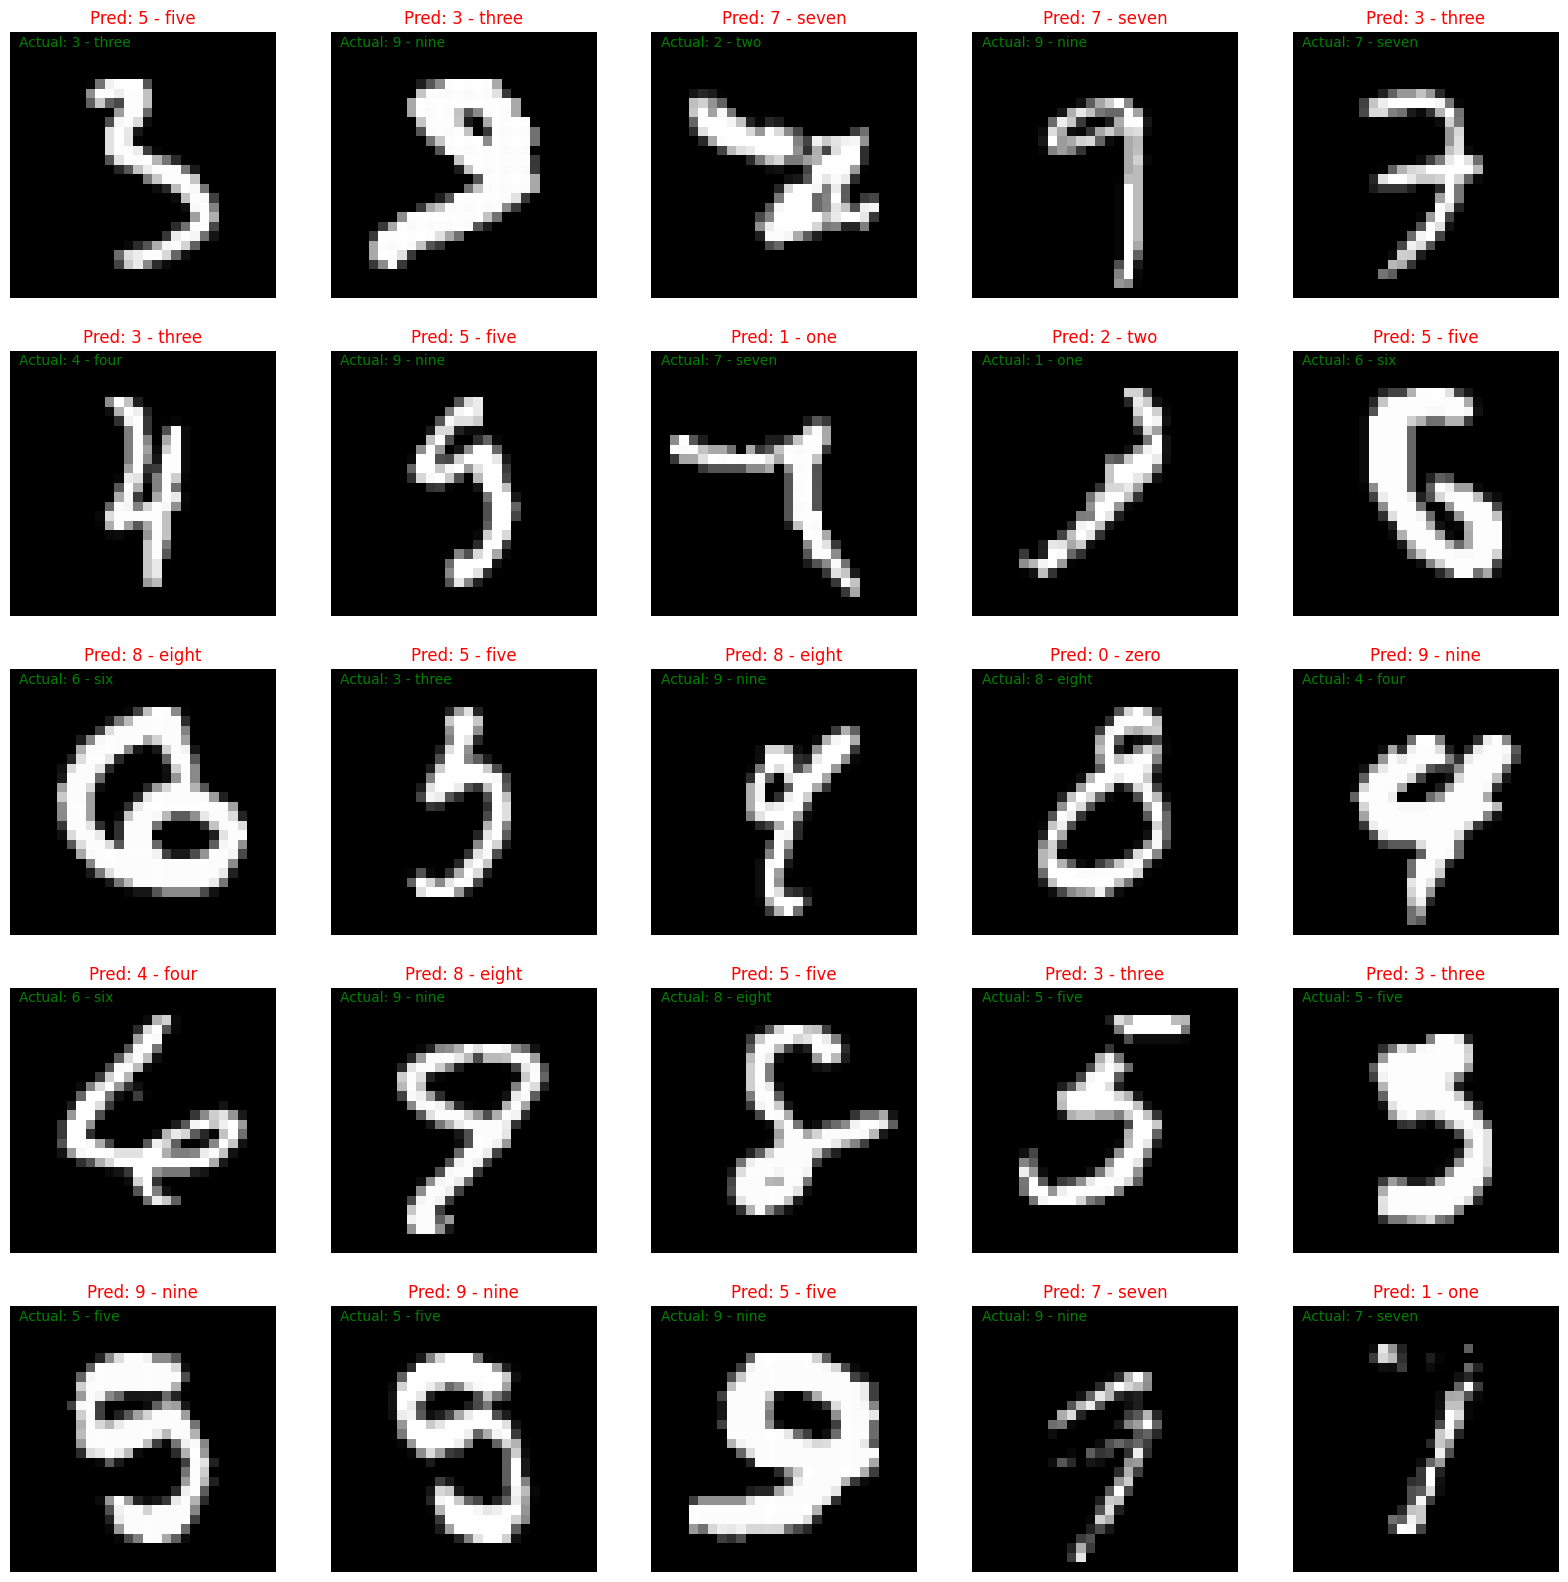

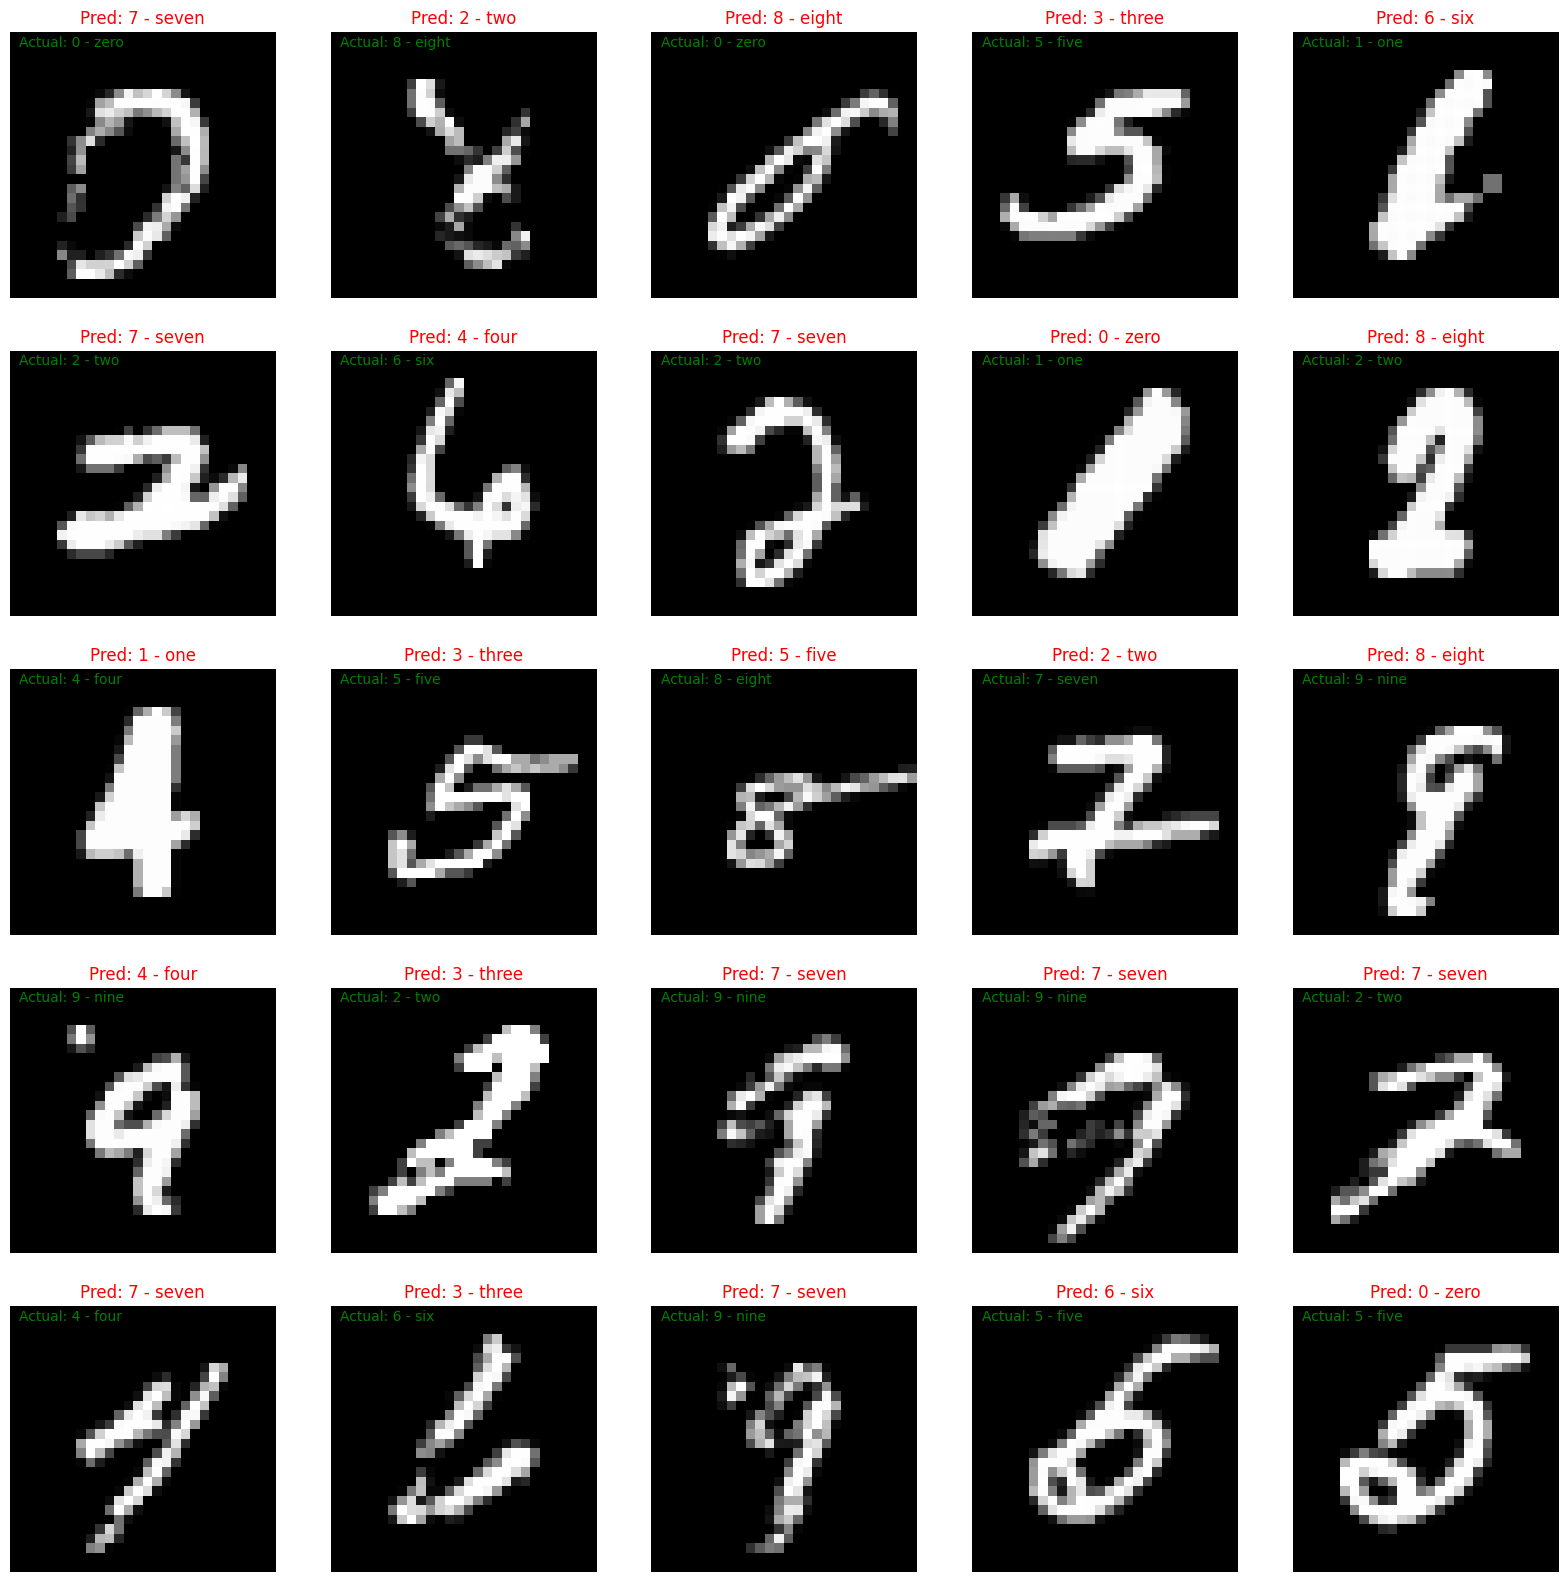

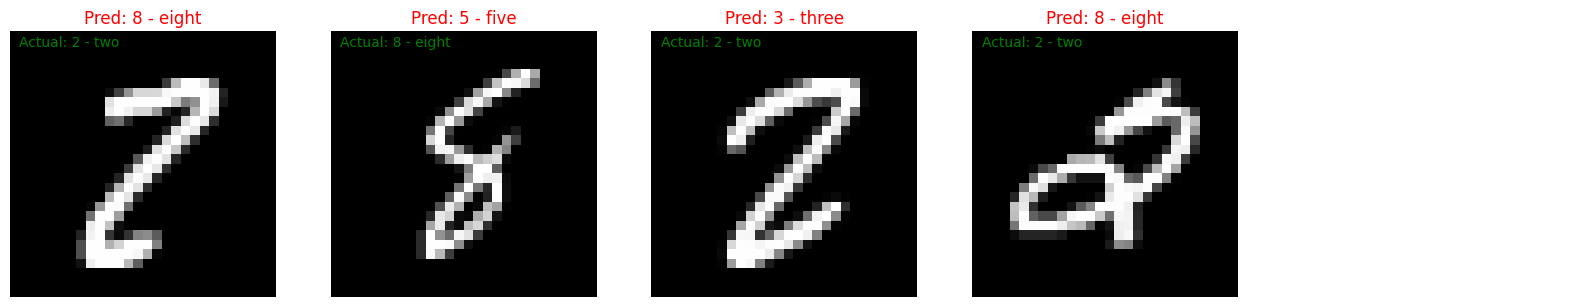

In [84]:
plt.figure(figsize=(20,20))
count=1
for i, y in enumerate(y_pred_tensor):
    if count > 25:
        plt.figure(figsize=(20, 20))
        count = 1
    plt.subplot(5, 5, count)
    plt.axis(False)
    if y != test_data.targets[i]:
        count+=1
        plt.imshow(test_data[i][0].squeeze(), cmap="gray")
        predStr = f"Pred: {class_names[y]}"
        targetStr = f"Actual: {class_names[test_data.targets[i]]}"
        # plt.title(f"Pred: {class_names[y]}| Actual: {class_names[test_data.targets[i]]}")
        plt.title(predStr, color = 'red')
        plt.text(.5, 1, targetStr, color='green')

## Save the model

In [89]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
MODEL_NAME = "MNIST_CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME 
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)